### reads in the BAA, convert to 0 to 360, do the same for the masks, combine and extract Pacific domain

In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr

In [55]:
import salem
import fiona

In [3]:
from glob import glob

### past 4 months, 7 days chunks 

In [4]:
dpath = '/Volumes/GDATA/data/CRW/BAA7dMAX/'

In [5]:
lfiles = glob(os.path.join(dpath, 'b5km_baa-max-7d_*.nc'))

In [6]:
lfiles.sort()

### selects the past 4 weeks

In [7]:
lfiles = lfiles[-4:]

In [8]:
lfiles

['/Volumes/GDATA/data/CRW/BAA7dMAX/b5km_baa-max-7d_20180109.nc',
 '/Volumes/GDATA/data/CRW/BAA7dMAX/b5km_baa-max-7d_20180116.nc',
 '/Volumes/GDATA/data/CRW/BAA7dMAX/b5km_baa-max-7d_20180123.nc',
 '/Volumes/GDATA/data/CRW/BAA7dMAX/b5km_baa-max-7d_20180130.nc']

### reads in the BAA 7 days max for the past 4 weeks

In [9]:
BAA = xr.open_mfdataset(lfiles)

In [10]:
BAA

<xarray.Dataset>
Dimensions:        (lat: 3600, lon: 7200, time: 4)
Coordinates:
  * lat            (lat) float32 89.975 89.925 89.875 89.825 89.775 89.725 ...
  * lon            (lon) float32 -179.975 -179.925 -179.875 -179.825 ...
  * time           (time) datetime64[ns] 2018-01-09T12:00:00 ...
Data variables:
    surface_flag   (time, lat, lon) int8 dask.array<shape=(4, 3600, 7200), chunksize=(1, 3600, 7200)>
    CRW_BAA_max7d  (time, lat, lon) float64 dask.array<shape=(4, 3600, 7200), chunksize=(1, 3600, 7200)>
    crs            (time) int16 -32767 -32767 -32767 -32767
Attributes:
    Conventions:                CF-1.6, ACDD-1.3, Unidata Observation Dataset...
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    title:                      NOAA Coral Reef Watch Daily Global 5-km Satel...
    summary:                    This is a product of NOAA Coral Reef Watch da...
    references:                 Liu, G, Heron SF, Eakin CM, Muller-Karger FE,...
    institution:    

In [11]:
last_date = BAA.time[-1].data.astype('M8[D]').astype('O')

### calculates the max over the past 4 weeks 

In [12]:
BAA = BAA.max('time')

In [13]:
BAA

<xarray.Dataset>
Dimensions:        (lat: 3600, lon: 7200)
Coordinates:
  * lat            (lat) float32 89.975 89.925 89.875 89.825 89.775 89.725 ...
  * lon            (lon) float32 -179.975 -179.925 -179.875 -179.825 ...
Data variables:
    surface_flag   (lat, lon) int8 dask.array<shape=(3600, 7200), chunksize=(3600, 7200)>
    CRW_BAA_max7d  (lat, lon) float64 dask.array<shape=(3600, 7200), chunksize=(3600, 7200)>
    crs            int16 -32767

### goes from 0 to 360 

In [14]:
BAA = BAA.assign_coords(lon=(BAA.lon % 360)).roll(lon=(BAA.dims['lon'] // 2))

### selects the Pacific region

In [15]:
BAA = BAA.sel(lon=slice(100, 300), lat=slice(50, -50))

/Users/nicolasf/anaconda3/envs/IOOS/lib/python3.5/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/Users/nicolasf/anaconda3/envs/IOOS/lib/python3.5/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


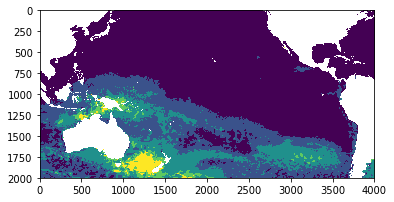

In [16]:
plt.imshow(BAA['CRW_BAA_max7d'].data)

### loads in memory

In [17]:
BAA.load()

/Users/nicolasf/anaconda3/envs/IOOS/lib/python3.5/site-packages/dask/compatibility.py:47: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/Users/nicolasf/anaconda3/envs/IOOS/lib/python3.5/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


<xarray.Dataset>
Dimensions:        (lat: 2000, lon: 4000)
Coordinates:
  * lat            (lat) float32 49.975 49.925 49.875 49.825 49.775 49.725 ...
  * lon            (lon) float32 100.025 100.075 100.125 100.175 100.225 ...
Data variables:
    surface_flag   (lat, lon) int8 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
    CRW_BAA_max7d  (lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
    crs            int16 -32767

### saves to disk 

In [18]:
BAA.to_netcdf(os.path.join(dpath, 'baa-max-7d_to_{:%Y-%m-%d}.nc'.format(last_date)))

### closes

In [19]:
BAA.close()

### reads in the masks

In [20]:
masks = xr.open_dataset('../data/reef_mask/compiled_5km_reef_mask_for_edit_20171113_buffer4pix.nc')

In [21]:
masks

<xarray.Dataset>
Dimensions:    (lat: 3600, lon: 7200)
Coordinates:
  * lat        (lat) float32 89.975 89.925 89.875 89.825 89.775 89.725 ...
  * lon        (lon) float32 -179.975 -179.925 -179.875 -179.825 -179.775 ...
Data variables:
    reef_mask  (lat, lon) uint8 ...
    land_mask  (lat, lon) uint8 ...

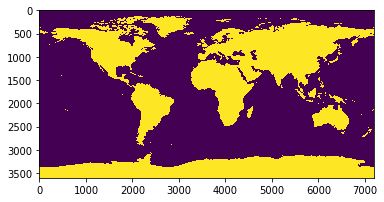

In [22]:
plt.imshow(masks['land_mask'].data)

In [23]:
masks_rolled = masks.assign_coords(lon=(masks.lon % 360)).roll(lon=(masks.dims['lon'] // 2))

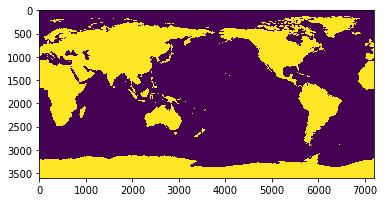

In [24]:
plt.imshow(masks_rolled['land_mask'].data)

In [25]:
land_mask = ~(masks_rolled['land_mask'].data.astype(np.bool))

In [26]:
land_mask = land_mask.astype(np.float32)

In [27]:
land_mask

array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

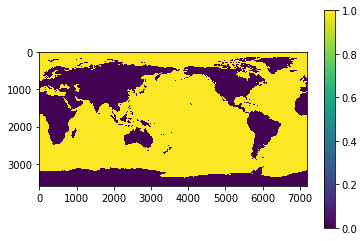

In [28]:
plt.imshow(land_mask); plt.colorbar()

In [29]:
masks_rolled['land_mask'] = (('lat','lon'), land_mask)

In [30]:
masks_rolled = masks_rolled.sel(lon=slice(100, 300), lat=slice(50, -50))

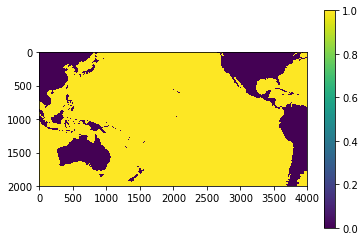

In [31]:
plt.imshow(masks_rolled['land_mask'].data); plt.colorbar()

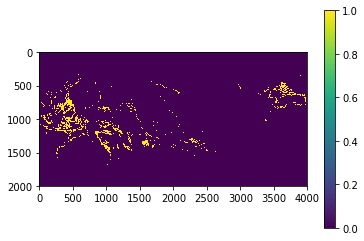

In [32]:
plt.imshow(masks_rolled['reef_mask'].data); plt.colorbar()

In [33]:
mask = masks_rolled['reef_mask'] * masks_rolled['land_mask']

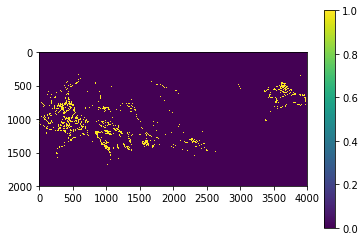

In [34]:
plt.imshow(mask); plt.colorbar()

In [35]:
mask_data = mask.data

In [36]:
mask_data[np.where(mask_data == 0)] = np.nan

In [37]:
d = {}
d['lat'] = (('lat'), mask.lat.data)
d['lon'] = (('lon'), mask.lon.data)
d['mask'] = (('lat','lon'), mask_data)

In [38]:
mask_dset = xr.Dataset(d)

In [39]:
mask_dset.to_netcdf('../data/combined_reef_mask.nc')

In [40]:
mask_data

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]], dtype=float32)

In [41]:
BAA['reef_mask'] = (('lat','lon'), mask_data)

In [42]:
if os.path.exists('../outputs/tmp.nc'):
    os.remove('../outputs/tmp.nc')

In [43]:
BAA.to_netcdf('../outputs/tmp.nc')

### reads the EEZ shapefile

In [44]:
shp_path = "/Users/nicolasf/drives/auck_projects/ICU14101/Working/ICU Water Watch/GIS map files"

In [45]:
shp = salem.read_shapefile(os.path.join(shp_path, "ALL_ICU_countries.shp"))

In [46]:
# shp.plot()

In [47]:
shp.head()

,COUNTRY_ID,COUNTRYNAM,ICU,Stress,SOPAC,FFA,SPC,SPREP,USP,TCSP,FORUM,ACP,area,geometry,min_x,max_x,min_y,max_y
0,NC,New Caledonia,2,-7,0,0,0,3,0,0,0,0,0.0,"POLYGON ((158.6108 -25.14667, 157.8011 -23.248...",156.255600,170.033300,-25.919891,-14.769438
1,PN,Pitcairn Islands,2,2,0,0,0,2,0,0,0,0,0.0,"POLYGON ((-132.499382 -22.511733, -132.228513 ...",-133.405666,-121.133705,-28.385089,-20.530577
2,PG,Papua New Guinea,-3,1,3,0,0,4,0,0,0,0,0.0,"POLYGON ((157.168058 -13.692712, 157.038334 -1...",139.200227,162.801941,-14.750038,2.591944
3,SB,Solomon Islands,2,10,2,0,0,4,0,0,0,0,0.0,"POLYGON ((173.5906 -11.85417, 173.525754 -12.5...",154.585556,173.590600,-16.133050,-4.142221
4,KI,Kiribati: Phoenix Islands,-5,-13,0,0,0,0,0,0,0,0,0.0,"POLYGON ((-168.921636 -6.882211000000032, -170...",-177.883300,-167.366700,-7.785231,0.583333


In [48]:
def sanitize(x): 
    x = x.replace(" ","_")
    x = x.replace("/","")
    x = x.replace(":","")
    return x

In [49]:
shp.loc[:,'COUNTRYNAM']= shp.loc[:,'COUNTRYNAM'].apply(sanitize)

In [50]:
shp.head()

,COUNTRY_ID,COUNTRYNAM,ICU,Stress,SOPAC,FFA,SPC,SPREP,USP,TCSP,FORUM,ACP,area,geometry,min_x,max_x,min_y,max_y
0,NC,New_Caledonia,2,-7,0,0,0,3,0,0,0,0,0.0,"POLYGON ((158.6108 -25.14667, 157.8011 -23.248...",156.255600,170.033300,-25.919891,-14.769438
1,PN,Pitcairn_Islands,2,2,0,0,0,2,0,0,0,0,0.0,"POLYGON ((-132.499382 -22.511733, -132.228513 ...",-133.405666,-121.133705,-28.385089,-20.530577
2,PG,Papua_New_Guinea,-3,1,3,0,0,4,0,0,0,0,0.0,"POLYGON ((157.168058 -13.692712, 157.038334 -1...",139.200227,162.801941,-14.750038,2.591944
3,SB,Solomon_Islands,2,10,2,0,0,4,0,0,0,0,0.0,"POLYGON ((173.5906 -11.85417, 173.525754 -12.5...",154.585556,173.590600,-16.133050,-4.142221
4,KI,Kiribati_Phoenix_Islands,-5,-13,0,0,0,0,0,0,0,0,0.0,"POLYGON ((-168.921636 -6.882211000000032, -170...",-177.883300,-167.366700,-7.785231,0.583333


In [51]:
dset_salem = salem.open_xr_dataset('../outputs/tmp.nc')

In [52]:
dset_salem

<xarray.Dataset>
Dimensions:        (lat: 2000, lon: 4000)
Coordinates:
  * lat            (lat) float32 49.975 49.925 49.875 49.825 49.775 49.725 ...
  * lon            (lon) float32 100.025 100.075 100.125 100.175 100.225 ...
Data variables:
    surface_flag   (lat, lon) int8 ...
    CRW_BAA_max7d  (lat, lon) float64 ...
    crs            int16 ...
    reef_mask      (lat, lon) float32 ...
Attributes:
    pyproj_srs:  +units=m +proj=latlong +datum=WGS84 

In [53]:
shp.COUNTRYNAM.unique()

array(['New_Caledonia', 'Pitcairn_Islands', 'Papua_New_Guinea',
       'Solomon_Islands', 'Kiribati_Phoenix_Islands', 'Fiji', 'Tuvalu',
       'Northern_Cook_Islands', 'Kiribati_Line_Islands',
       'Federated_States_of_Micronesia', 'Samoa',
       'Kiribati_Gilbert_Islands', 'Wallis_&_Futuna', 'Tokelau',
       'Tuamotu__Gambier_Islands', 'Tonga', 'Niue',
       'Southern_Cook_Islands', 'Austral_Islands', 'Society_Islands',
       'Marquesas', 'Vanuatu_South', 'Vanuatu_North', 'Guam',
       'Northern_Marianas', 'Marshall_Islands', 'Nauru', 'Palau',
       'American_Samoa'], dtype=object)

In [57]:
for country_name in shp.COUNTRYNAM.unique(): 
#     sh_country = shp.query("COUNTRYNAM == '{}'".format(country_name))
#     sh_country.to_file('../shapefiles/shapes_{}'.format(country_name))
#     sh_country = fiona.open('../shapefiles/shapes_{}'.format(country_name))
#     convert_shape(country_name)
    sh_country = salem.read_shapefile('../shapefiles/shapes_{}_converted.shp'.format(country_name))
    ds_subset = dset_salem.salem.subset(shape=sh_country, margin=2)
    ds_subset_roi = ds_subset.salem.roi(shape=sh_country)
    masked_roi = ds_subset_roi['CRW_BAA_max7d'] * ds_subset_roi['reef_mask']
    masked_roi = masked_roi.stack(z=('lat','lon'))
    df = masked_roi.to_dataframe(name='masked_roi')
    df_na = df.dropna()
    summary  = df_na.describe(percentiles=[0.1, 0.25, 0.5, 0.6, 0.7, 0.8, 0.9])
    summary = summary.T
    counts = pd.value_counts(df_na.iloc[:,0])
    counts = counts.reindex(range(5))
    counts = counts.replace(np.nan, 0)
    counts = counts.to_frame().T
    summary = pd.concat([summary, counts], axis=1)
    summary.index.name = "country"
    summary.index = [country_name]
    summary.to_csv('../outputs/{}_summary.csv'.format(country_name))

In [58]:
!ls ../outputs/

American_Samoa_summary.csv
Austral_Islands_summary.csv
BAA
BAA_4weeks_max.csv
BAA_4weeks_max_to_180107.csv
BAA_4weeks_max_to_20180107.csv
CSFV2_outlook_monthly_90th_per_summary_table_from_20171210.csv
CSFV2_outlook_monthly_90th_per_summary_table_from_20180114.csv
CSFV2_outlook_summary_table_from_20171210.csv
CSFV2_outlook_weekly_90th_per_summary_table_from_20171210.csv
CSFV2_outlook_weekly_90th_per_summary_table_from_20180114.csv
CSFV2_outlook_weekly_90th_per_summary_table_from__20180114.csv
Federated_States_of_Micronesia_summary.csv
Fiji_summary.csv
Guam_summary.csv
Kiribati_Gilbert_Islands_summary.csv
Kiribati_Line_Islands_summary.csv
Kiribati_Phoenix_Islands_summary.csv
Marquesas_summary.csv
Marshall_Islands_summary.csv
Nauru_summary.csv
New_Caledonia_summary.csv
Niue_summary.csv
Northern_Cook_Islands_summary.csv
Northern_Marianas_summary.csv
Palau_summary.csv
Papua_New_Guinea_summary.csv
Pitcairn_Islands_summary.csv
Samoa_summary.csv
Society_Islands_summary.csv
Solomon_Islands_summ

In [59]:
lfiles = glob("../outputs/*_summary.csv")

In [60]:
len(lfiles)

29

In [61]:
data = pd.read_csv(lfiles[0], index_col=0)

In [62]:
data

,count,mean,std,min,10%,25%,50%,60%,70%,80%,90%,max,0,1,2,3,4
New_Caledonia,4647.0,1.08371,0.28389,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,9.0,4240.0,398.0,0.0,0.0


In [63]:
dl = [] 
for f in lfiles: 
    d = pd.read_csv(f, index_col=0)
    dl.append(d)

In [64]:
dlf = pd.concat(dl, axis=0)

In [65]:
dlf

,count,mean,std,min,10%,25%,50%,60%,70%,80%,90%,max,0,1,2,3,4
New_Caledonia,4647.0,1.083710,0.283890,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,9.0,4240.0,398.0,0.0,0.0
Tonga,1616.0,1.145421,0.352634,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,1381.0,235.0,0.0,0.0
Kiribati_Phoenix_Islands,612.0,0.544118,0.498457,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,279.0,333.0,0.0,0.0,0.0
Tuvalu,1339.0,1.383122,0.486329,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,0.0,826.0,513.0,0.0,0.0
Tokelau,236.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,236.0,0.0,0.0,0.0
Society_Islands,1337.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1337.0,0.0,0.0,0.0
Austral_Islands,560.0,0.817857,0.386307,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,102.0,458.0,0.0,0.0,0.0
Federated_States_of_Micronesia,5229.0,1.005928,0.076775,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,5198.0,31.0,0.0,0.0
Solomon_Islands,6016.0,2.028424,0.229256,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,0.0,75.0,5695.0,246.0,0.0
Pitcairn_Islands,242.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,242.0,0.0,0.0,0.0


In [69]:
dict_names = {'Palau':'Palau',
'Federated_States_of_Micronesia':'FSM',
'Guam':'Guam',
'Northern_Marianas':'Northern Marianas',
'Marshall_Islands':'Marshall Islands',
'Nauru':'Nauru',
'Kiribati_Gilbert_Islands':'Kiribati (Gilbert)',
'Kiribati_Phoenix_Islands':'Kiribati (Phoenix)',
'Kiribati_Line_Islands':'Kiribati (Line)',
'Papua_New_Guinea':'Papua New Guinea',
'Solomon_Islands':'Solomon Islands',
'New_Caledonia':'New Caledonia',
'Vanuatu_North':'Vanuatu North',
'Vanuatu_South':'Vanuatu South',
'Fiji':'Fiji',
'Tuvalu':'Tuvalu',
'Wallis_&_Futuna':'Wallis & Futuna',
'Tokelau':'Tokelau',
'Tonga':'Tonga',
'Samoa':'Samoa',
'American_Samoa':'American Samoa',
'Niue':'Niue',
'Northern_Cook_Islands':'Northern Cook Islands',
'Southern_Cook_Islands':'Southern Cook Islands',
'Society_Islands':'Society Islands',
'Austral_Islands':'Austral Islands',
'Tuamotu__Gambier_Islands':'Tuamotu/Gambier',
'Marquesas':'Marquesas',
'Pitcairn_Islands':'Pitcairn Islands'}

In [70]:
dlf.index = [dict_names[x] for x in dlf.index]

In [72]:
dlf

,count,mean,std,min,10%,25%,50%,60%,70%,80%,90%,max,0,1,2,3,4
New Caledonia,4647.0,1.083710,0.283890,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,9.0,4240.0,398.0,0.0,0.0
Tonga,1616.0,1.145421,0.352634,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,1381.0,235.0,0.0,0.0
Kiribati (Phoenix),612.0,0.544118,0.498457,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,279.0,333.0,0.0,0.0,0.0
Tuvalu,1339.0,1.383122,0.486329,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,0.0,826.0,513.0,0.0,0.0
Tokelau,236.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,236.0,0.0,0.0,0.0
Society Islands,1337.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1337.0,0.0,0.0,0.0
Austral Islands,560.0,0.817857,0.386307,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,102.0,458.0,0.0,0.0,0.0
FSM,5229.0,1.005928,0.076775,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0,5198.0,31.0,0.0,0.0
Solomon Islands,6016.0,2.028424,0.229256,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,0.0,75.0,5695.0,246.0,0.0
Pitcairn Islands,242.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,242.0,0.0,0.0,0.0


In [73]:
dlf.to_csv('../outputs/BAA_4weeks_max_summary.csv')

In [67]:
dlf.sort_values("90%", ascending=False)

,count,mean,std,min,10%,25%,50%,60%,70%,80%,90%,max,0,1,2,3,4
Papua_New_Guinea,12824.0,2.380147,0.638749,1.0,2.0,2.0,2.0,2.8,3.0,3.0,3.0,4.0,0.0,680.0,7014.0,4705.0,425.0
Nauru,66.0,1.833333,0.375534,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,11.0,55.0,0.0,0.0
Wallis_&_Futuna,967.0,1.726991,0.445736,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,264.0,703.0,0.0,0.0
Niue,142.0,1.140845,0.647872,0.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,21.0,80.0,41.0,0.0,0.0
Tuvalu,1339.0,1.383122,0.486329,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,0.0,826.0,513.0,0.0,0.0
Fiji,5578.0,1.115991,0.320243,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,4931.0,647.0,0.0,0.0
Solomon_Islands,6016.0,2.028424,0.229256,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,0.0,75.0,5695.0,246.0,0.0
Samoa,395.0,1.478481,0.500170,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,0.0,206.0,189.0,0.0,0.0
American_Samoa,331.0,1.274924,0.447152,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,0.0,240.0,91.0,0.0,0.0
Tonga,1616.0,1.145421,0.352634,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,1381.0,235.0,0.0,0.0


In [68]:
!open ../outputs/BAA_4weeks_max_summary.csv